# 01_ndmi_cdmx_graphs

#### __Notebook based on cutzamala/04_ndmi_cdmx_graphs__

This notebook does the same as __cutzamala/04_ndmi_cdmx_graphs__, but including alcaldía Álvaro Obregón.

This notebook loads the output of cutzamala/03b_ndmi_cdmx_maps and creates a lineplot that shows how the alcaldías where households have the most frequency and reliability in their water service keep a higher average NDMI than the alcaldías where households have the less frequency and reliability on their water service.

* Water service frequency and reliability from ENIGH, INEGI

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## 1. Load previously processed data (Notebook cutzamala/03b_ndmi_cdmx_maps)

In [2]:
save_dir = f'../../../data/external/temporal_fromjupyter/'
mean_ndmi_bydate = gpd.read_file(save_dir+"cutzamala/cdmx_enemay_ndmi.gpkg")

# Show
print(mean_ndmi_bydate.shape)
mean_ndmi_bydate.head(1)

(35317, 10)


,hex_id,NOMGEO,ene-may_2018,ene-may_2019,ene-may_2020,ene-may_2021,ene-may_2022,ene-may_2023,ene-abr_2024,geometry
0,8a4995b88d67fff,Azcapotzalco,0.105919,0.147756,0.087584,0.035289,0.086562,0.028519,0.033012,"POLYGON ((-99.17778 19.49754, -99.17713 19.497..."


## 2. Data analysis

In [5]:
# Data of interest
time_periods = ['ene-may_2018','ene-may_2019',
                'ene-may_2020','ene-may_2021',
                'ene-may_2022','ene-may_2023',
                'ene-abr_2024']
mean_ndmi_bydate_f = mean_ndmi_bydate[['NOMGEO']+time_periods]

# Categorice alcaldías
# All alcaldías start with 'situation' 'middle'.
mean_ndmi_bydate_f['situation'] = 'middle'

# 4 TOP Alcaldías that have more frequency on reliable water service [INEGI, ENIGH]
top_water_frequency = ['Benito Juárez','Cuauhtémoc','Miguel Hidalgo','Venustiano Carranza']
# 4 BOTTOM Alcaldías that have less frequency on reliable water service [INEGI, ENIGH]
bottom_water_frequency = ['Xochimilco','Tlalpan','Tláhuac','Milpa Alta']

# Locate each case and assign situation to new col (more / less)
idx_more = mean_ndmi_bydate_f['NOMGEO'].isin(top_water_frequency)
mean_ndmi_bydate_f.loc[idx_more, 'situation'] = 'top'

idx_less = mean_ndmi_bydate_f['NOMGEO'].isin(bottom_water_frequency)
mean_ndmi_bydate_f.loc[idx_less, 'situation'] = 'bottom'

mean_ndmi_bydate_f

/tmp/ipykernel_33896/3059550427.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_ndmi_bydate_f['situation'] = 'middle'


,NOMGEO,ene-may_2018,ene-may_2019,ene-may_2020,ene-may_2021,ene-may_2022,ene-may_2023,ene-abr_2024,situation
0,Azcapotzalco,0.105919,0.147756,0.087584,0.035289,0.086562,0.028519,0.033012,middle
1,Azcapotzalco,0.037642,0.031787,0.044080,0.040128,0.033321,0.029482,0.032508,middle
2,Azcapotzalco,0.005989,-0.005167,-0.011358,-0.020786,0.002482,-0.007598,-0.006222,middle
3,Azcapotzalco,0.104418,0.105524,0.125967,0.104106,0.086681,0.073300,0.091176,middle
4,Azcapotzalco,0.017313,0.015597,0.027663,0.025225,0.015952,0.011709,0.021039,middle
...,...,...,...,...,...,...,...,...,...
35312,Venustiano Carranza,0.113010,0.108066,0.080905,0.031761,0.079986,0.048547,0.052662,top
35313,Venustiano Carranza,-0.010727,-0.034766,-0.071402,-0.097678,-0.039400,-0.079977,-0.051626,top
35314,Venustiano Carranza,0.020229,0.009981,0.027224,0.010948,0.017089,0.005639,0.009055,top
35315,Venustiano Carranza,-0.022538,-0.023175,0.006531,0.028634,0.019975,0.005070,0.011997,top


### Calculate plot data (by individual alcaldía of interest)

In [7]:
# Group by preparation (needs NOMGEO and data only, drop situation)
mean_ndmi_bydate_ff = mean_ndmi_bydate_f.copy()
mean_ndmi_bydate_ff.drop(columns=['situation'],inplace=True)
# Group by
grouped_by = mean_ndmi_bydate_ff.groupby(['NOMGEO']).mean()
grouped_by.reset_index(inplace=True)

# Keep all alcaldías of interest
#mean_ndmi_alcaldias = grouped_by.loc[grouped_by['NOMGEO'].isin(top_water_frequency + bottom_water_frequency)]

# Transpose data (for plot)
df_individual = grouped_by.transpose()
df_individual.columns = df_individual.iloc[0]
df_individual.drop(index='NOMGEO', axis=1, inplace=True)
df_individual

NOMGEO,Azcapotzalco,Benito Juárez,Coyoacán,Cuajimalpa de Morelos,Cuauhtémoc,Gustavo A. Madero,Iztacalco,Iztapalapa,La Magdalena Contreras,Miguel Hidalgo,Milpa Alta,Tlalpan,Tláhuac,Venustiano Carranza,Xochimilco,Álvaro Obregón
ene-may_2018,0.030588,0.039709,0.043811,0.158084,0.043398,-0.01315,0.021721,-0.02055,0.117599,0.071898,-0.01915,0.026601,-0.055378,0.02836,-0.002858,0.079553
ene-may_2019,0.028615,0.034987,0.035031,0.145235,0.045067,-0.026044,0.014614,-0.033674,0.098644,0.067176,-0.028954,0.016684,-0.084304,0.020294,-0.024783,0.071737
ene-may_2020,0.033543,0.048563,0.042739,0.155887,0.057696,-0.033012,0.029467,-0.039748,0.102086,0.075933,-0.049125,0.013059,-0.087603,0.021115,-0.022017,0.075898
ene-may_2021,0.021097,0.038696,0.028327,0.120951,0.055933,-0.052015,0.021856,-0.047476,0.072535,0.052887,-0.059067,-0.008885,-0.093578,0.003012,-0.039449,0.048556
ene-may_2022,0.024825,0.034612,0.031537,0.108883,0.042751,-0.014832,0.020614,-0.026244,0.074682,0.052827,-0.023052,0.013111,-0.05659,0.013201,-0.004392,0.054257
ene-may_2023,0.01073,0.021388,0.023057,0.090383,0.028149,-0.03478,0.007192,-0.034814,0.065823,0.033846,-0.0377,0.002224,-0.069049,-0.002797,-0.020636,0.044335
ene-abr_2024,0.022698,0.031772,0.025512,0.084648,0.041494,-0.02397,0.013572,-0.031676,0.061197,0.036276,-0.027665,0.011353,-0.0657,0.012324,-0.019341,0.038457


### Calculate plot data (by group of alcaldías of interest)

In [8]:
# Group by preparation (needs situation and data only)
mean_ndmi_bydate_ff = mean_ndmi_bydate_f.copy()
mean_ndmi_bydate_ff.drop(columns=['NOMGEO'],inplace=True)
# Group by
grouped_by = mean_ndmi_bydate_ff.groupby(['situation']).mean()
grouped_by.reset_index(inplace=True)

# Transpose data (for plot)
df_grouped = grouped_by.transpose()
df_grouped.columns = df_grouped.iloc[0]
df_grouped.drop(index='situation', axis=1, inplace=True)
df_grouped

situation,bottom,middle,top
ene-may_2018,-0.003455,0.072293,0.058954
ene-may_2019,-0.01923,0.061128,0.054775
ene-may_2020,-0.024947,0.065036,0.064157
ene-may_2021,-0.040645,0.041352,0.046541
ene-may_2022,-0.009816,0.047593,0.044984
ene-may_2023,-0.023214,0.034718,0.027805
ene-abr_2024,-0.01677,0.034035,0.034108


### Plot data

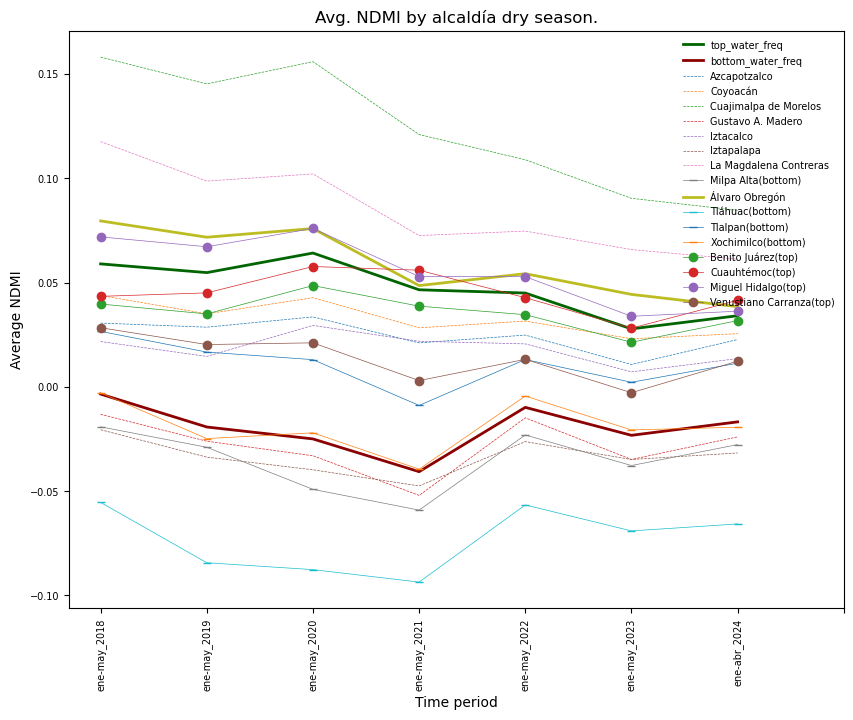

In [28]:
# Plot by situation (alcaldías with more water frequency vs alcaldías with less water frequency)

#Plot by situation
fig, ax = plt.subplots(figsize=(10,7.5))
x = time_periods

situations = ['top','bottom']
for situation in situations:
    y = df_grouped[situation]

    if situation == 'top':
        plt.plot(x, y, linewidth = 2, label='top_water_freq', color = 'darkgreen')
    elif situation == 'bottom':
        plt.plot(x, y, linewidth = 2, label='bottom_water_freq', color = 'darkred')

#Plot by alcaldia
for alcaldia in list(mean_ndmi_bydate.NOMGEO.unique()):
    # Current alcaldia
    y = df_individual[alcaldia]
    if alcaldia in top_water_frequency:
        plt.plot(x,y,'-o',linewidth = 0.5, label = f"{alcaldia}(top)")
    elif alcaldia in bottom_water_frequency:
        plt.plot(x,y,'-_',linewidth = 0.5, label = f"{alcaldia}(bottom)")
    elif alcaldia == "Álvaro Obregón":
        plt.plot(x,y,linewidth = 2, label = f"{alcaldia}")
    else:
        plt.plot(x,y,'--',linewidth = 0.5, label = f"{alcaldia}")

# ---------- FORMAT ----------
# Format - Titles
plt.title('Avg. NDMI by alcaldía dry season.')
plt.xlabel('Time period')
plt.ylabel('Average NDMI')

# Format - x ticks
# Tag all 8 time periods
plt.xticks(np.arange(0, 8))
# Rotate ticks
x = plt.gca().xaxis
for item in x.get_ticklabels():
    item.set_rotation(90)
    item.set_size(7)

# Format - y ticks
y = plt.gca().yaxis
for item in y.get_ticklabels():
    item.set_size(7)

# Format - Legend
plt.legend(frameon=False,
           loc=1, 
           fontsize = 7)

#plt.savefig("../../../output/figures/ndmi/cutzamala/avg_ndmi_topbottom_alcaldias_cdmx.svg")